### Modèle pour classification des types de cellules sans IG 

> Les cellules de type IG amène de la confusion dans les prédictions
>
> Entrainement d'un modèle sur les 7 autres types pour voir la précision du modèle

In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

from tensorflow.keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from sklearn import metrics


In [2]:
src_img = '../images_mendeley/dataset_redim/'

#### Récupération de la base d'images et création jeu d'évaluation, de test et d'entrainement

In [3]:
data = pd.read_csv('../mendeley_cells_redim.csv',index_col=0)

In [4]:
# Retire les IG
data_no_IG = data[data['category']!='ig']
data_no_IG['category'].value_counts()

neutrophil      3329
eosinophil      3117
platelet        2348
erythroblast    1551
monocyte        1420
basophil        1218
lymphocyte      1214
Name: category, dtype: int64

In [5]:
data_train, data_eval = train_test_split(data_no_IG,test_size=0.1,random_state=123)
data_train, data_test = train_test_split(data_train,test_size=0.2,random_state=123)

#### Utilisation d'un ImageDataGenerator sans transformation pour simplement redimensionné les images en 224*224 et chargé depuis un path

In [6]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [7]:
train_generator = data_generator.flow_from_dataframe(data_train, directory=src_img, x_col='filename',y_col='category',class_mode ='sparse',target_size=(224,224),
                                              batch_size=32)

test_generator = data_generator.flow_from_dataframe(data_test, directory=src_img, x_col='filename',y_col='category',class_mode ='sparse',target_size=(224,224),
                                              batch_size=32)

Found 10221 validated image filenames belonging to 7 classes.
Found 2556 validated image filenames belonging to 7 classes.


#### Transfer Learning avec modèle VGG16 
* Freeze de toutes les couches
* Couches Dense 1024, 512, 256 
* Pas de Dropout pour le moment
* Compilation avec SGD avec learning_rate de 1e-4  et momentum 0.9

In [19]:
# Création Callback pour stopper si pas stagnation
callback = EarlyStopping(monitor='val_loss', patience=2,restore_best_weights=True)

In [9]:
base_model = VGG16(weights='imagenet', include_top=False)
#Freeze les couches, entrainement sur la classification
for layer in base_model.layers: 
    layer.trainable = False    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=1024,activation='relu'))
model.add(Dense(units=512,activation='relu'))
model.add(Dense(units=256,activation='relu'))
model.add(Dense(units=7,activation='softmax')) #7 Classes (sans IG)

model.compile(optimizer=SGD(learning_rate=1e-4, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
#Entrainement
history = model.fit(train_generator, epochs = 16,batch_size = 32, validation_data = test_generator,callbacks=[callback])

Epoch 1/16
320/320 [==============================] - 4123s 13s/step - loss: 0.9331 - accuracy: 0.6910 - val_loss: 0.5301 - val_accuracy: 0.8271
Epoch 2/16
320/320 [==============================] - 4608s 14s/step - loss: 0.4541 - accuracy: 0.8566 - val_loss: 0.3980 - val_accuracy: 0.8642
Epoch 3/16
320/320 [==============================] - 3440s 11s/step - loss: 0.3527 - accuracy: 0.8896 - val_loss: 0.3148 - val_accuracy: 0.9010
Epoch 4/16
320/320 [==============================] - 3512s 11s/step - loss: 0.2966 - accuracy: 0.9077 - val_loss: 0.2771 - val_accuracy: 0.9143
Epoch 5/16
320/320 [==============================] - 3399s 11s/step - loss: 0.2663 - accuracy: 0.9172 - val_loss: 0.2524 - val_accuracy: 0.9190
Epoch 6/16
320/320 [==============================] - 3420s 11s/step - loss: 0.2453 - accuracy: 0.9248 - val_loss: 0.2325 - val_accuracy: 0.9206
Epoch 7/16
320/320 [==============================] - 3420s 11s/step - loss: 0.2223 - accuracy: 0.9329 - val_loss: 0.2239 - val_ac

In [11]:
model.save("vgg16_no_ig")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: vgg16_no_ig\assets


#### Prédiction sur les données d'évaluation avec entrainement classification uniquement

In [12]:
eval_generator = data_generator.flow_from_dataframe(data_eval, directory=src_img, x_col='filename',y_col='category',class_mode ='sparse',target_size=(224,224),
                                              batch_size=32,shuffle=False)
predict = model.predict(eval_generator)

Found 1420 validated image filenames belonging to 7 classes.


In [13]:
model.evaluate(eval_generator,batch_size=32)

45/45 [==============================] - 405s 9s/step - loss: 0.2264 - accuracy: 0.9169


[0.22639495134353638, 0.9169014096260071]

* Précision 91.6%, avec toutes les couches VGG16 freeze
* On regarde plus en détail les résultats

In [15]:
#Classes prédites
eval_predict_class = predict.argmax(axis = 1)
lst_classes = [key for key, val in eval_generator.class_indices.items()]
eval_predict_class_name = [lst_classes[i] for i in eval_predict_class]
eval_class_name = [lst_classes[i] for i in eval_generator.classes]
print(metrics.classification_report( eval_class_name,eval_predict_class_name ))

              precision    recall  f1-score   support

    basophil       0.98      0.90      0.94       124
  eosinophil       0.84      0.94      0.89       321
erythroblast       0.93      0.90      0.91       161
  lymphocyte       0.86      0.97      0.92       117
    monocyte       0.88      0.89      0.89       155
  neutrophil       0.99      0.86      0.92       324
    platelet       0.96      0.98      0.97       218

    accuracy                           0.92      1420
   macro avg       0.92      0.92      0.92      1420
weighted avg       0.92      0.92      0.92      1420



#### Fine Tunning 8 couches

In [16]:
# Unfreeze les 8 dernières couches VGG16
for layer in base_model.layers[-8:]: 
    layer.trainable = True

In [20]:
model.compile(optimizer=SGD(learning_rate=1e-4, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs = 16,batch_size = 32, validation_data = test_generator,callbacks=[callback])

Epoch 1/16
320/320 [==============================] - 6799s 21s/step - loss: 0.0321 - accuracy: 0.9902 - val_loss: 0.0410 - val_accuracy: 0.9890
Epoch 2/16
320/320 [==============================] - 6014s 19s/step - loss: 0.0132 - accuracy: 0.9967 - val_loss: 0.0329 - val_accuracy: 0.9918
Epoch 3/16
320/320 [==============================] - 6068s 19s/step - loss: 0.0063 - accuracy: 0.9984 - val_loss: 0.0502 - val_accuracy: 0.9844
Epoch 4/16
320/320 [==============================] - 6171s 19s/step - loss: 0.0026 - accuracy: 0.9996 - val_loss: 0.0396 - val_accuracy: 0.9914


In [21]:
model.save("vgg16_no_ig_fine_tunning")

INFO:tensorflow:Assets written to: vgg16_no_ig_fine_tunning\assets


In [22]:
predict = model.predict(eval_generator)
model.evaluate(eval_generator,batch_size=32)

45/45 [==============================] - 387s 9s/step - loss: 0.0494 - accuracy: 0.9880


[0.04940371960401535, 0.9880281686782837]

> Très bon score de 98.8%

In [23]:
eval_predict_class = predict.argmax(axis = 1)
eval_predict_class_name = [lst_classes[i] for i in eval_predict_class]
print(metrics.classification_report( eval_class_name,eval_predict_class_name ))

              precision    recall  f1-score   support

    basophil       0.99      1.00      1.00       124
  eosinophil       1.00      0.99      0.99       321
erythroblast       0.98      0.98      0.98       161
  lymphocyte       0.97      1.00      0.98       117
    monocyte       0.97      0.96      0.97       155
  neutrophil       0.99      0.99      0.99       324
    platelet       0.99      1.00      0.99       218

    accuracy                           0.99      1420
   macro avg       0.98      0.99      0.99      1420
weighted avg       0.99      0.99      0.99      1420



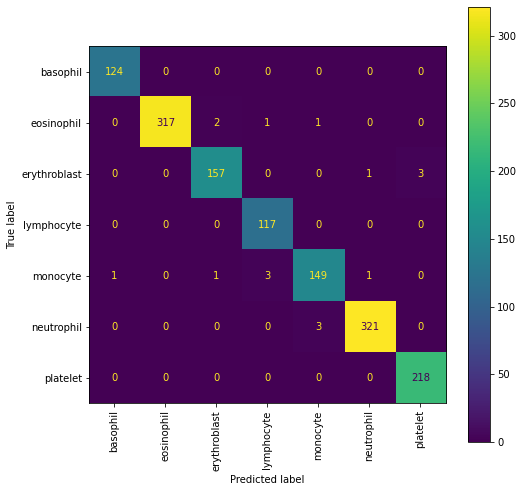

In [25]:
# Matrice de confusion
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
matrice = confusion_matrix(eval_class_name,eval_predict_class_name)
fig=plt.figure(figsize=(8,8))
ax = fig.add_subplot(111) 
ConfusionMatrixDisplay(matrice).plot(ax=ax)
plt.xticks(range(7),lst_classes,rotation=90)
plt.yticks(range(7),lst_classes);

> Le modèle est  plus performant sans les cellules de type IG